In [1]:
import numpy as np
import urllib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import models, optimizers
from keras import layers, losses
from keras import regularizers
from keras.utils import to_categorical
from keras.layers import BatchNormalization
import keras
import tensorflow as tf
import pandas as pd
import time
%matplotlib inline

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [20]:
def define_classification_model(noclasses = 3, num_layers = 1, num_neurons = [16], input_shape = (0,), 
                 loss = "categorical_crossentropy", optimizer = "RMSprop", optimizer_lr = 0, 
                 dropout = 0, regularizer = "L1", reg_rate = 0, batch_norm = False):
  
  assert input_shape[0] != 0
  assert num_layers == len(num_neurons)
  
  model = models.Sequential()
  
  for i in range(num_layers):
    if reg_rate:
      if regularizer == "l1":
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = keras.regularizers.l1(reg_rate),
                               activation = 'relu', input_shape = input_shape))
      elif regularizer == "l2":
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = keras.regularizers.l2(reg_rate),
                               activation = 'relu', input_shape = input_shape))
      elif regularizer == "l1_l2":
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = keras.regularizers.l1_l2(reg_rate),
                               activation = 'relu', input_shape = input_shape))
      else:
        print("WARNING: Invalid regularizer given. Using L1 regularization with 0.01 Regularization Rate.")
        model.add(layers.Dense(num_neurons[i], kernel_regularizer = regularizers.l1(0.01),
                               activation = 'relu', input_shape = input_shape))
    else:
      model.add(layers.Dense(num_neurons[i],  activation = 'relu', input_shape = input_shape))
      
    #Add dropout to all but the penultimate layer.
    if dropout:
      model.add(layers.Dropout(dropout))
    if batch_norm:
      model.add(BatchNormalization())
  
  model.add(layers.Dense(noclasses, activation = 'softmax'))
  
  
  if optimizer_lr == 0:
    optimizer_lr = 0.001
  
  if optimizer == "sgd":
    optimizer = optimizers.sgd(lr = optimizer_lr)
  elif optimizer == "RMSprop":
    optimizer = optimizers.RMSprop(lr = optimizer_lr)
  elif optimizer == "Adagrad":
    optimizer = optimizers.Adagrad(lr = optimizer_lr)
  else:
    print("!!WARNING: Incompatible Optimizer provided. Using RMSprop!!")
    optimizer = optimizers.RMSprop()

 
  loss_fn = ""
  if loss == "categorical_crossentropy":
    loss_fn = keras.losses.categorical_crossentropy
  elif loss == "hinge":
    loss_fn = keras.losses.hinge
  elif loss == "kl":
    loss_fn = keras.losses.kullback_leibler_divergence
  else:
    print("!!WARNING: Incompatible loss function given. Using categorical_crossentropy loss!!")
    loss_fn = keras.losses.categorical_crossentropy

  model.compile(optimizer = optimizer,
             loss = loss_fn,
             metrics = ["accuracy"])
  
  return model


In [21]:
def print_classification_graphs(history, epochs, batch_size, plot_title = "Metrics"):
  history_dict = history.history
  accuracy = history_dict['accuracy']
  val_accuracy = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
    
  fig = plt.figure(figsize=(15,7))
  fig.suptitle(plot_title, fontsize = 14, weight = 'bold')
  plt.subplot(1,2,1)
  plt.plot(range(epochs), accuracy, 'r', label = 'Train Accuracy')
  plt.plot(range(epochs), val_accuracy, 'b', label = 'Validation Accuracy')
  plt.legend()
  
  plt.subplot(1,2,2)
  plt.plot(range(epochs), loss, 'r', label = 'Train Loss')
  plt.plot(range(epochs), val_loss, 'b', label = 'Validation Loss')

  plt.legend()
  plt.show()

In [22]:
from keras.datasets import cifar10
def load_cifar_subset(noclasses = 3):
  (x_train_all, y_train_all), (x_test_all, y_test_all) = cifar10.load_data()
  
  nooffeatures = x_train_all.shape[1] * x_train_all.shape[2] * x_train_all.shape[3]
  
  x_train_all = x_train_all.reshape(-1, nooffeatures)
  x_test_all = x_test_all.reshape(-1, nooffeatures)

  train_keep = (y_train_all < noclasses).reshape(-1)
  test_keep = (y_test_all < noclasses).reshape(-1)

  y_train = y_train_all[train_keep,]
  x_train = x_train_all[train_keep,]
  y_test = y_test_all[test_keep,]
  x_test = x_test_all[test_keep,]

  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  return (x_train, y_train), (x_test, y_test)

In [23]:
noclasses = 3
(x_train, y_train), (x_test, y_test) = load_cifar_subset(noclasses)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
print("x_train: " + str(x_train.shape))
print("y_train: " + str(y_train.shape))
print("x_val: " + str(x_val.shape))
print("y_val: " + str(y_val.shape))
print("x_test: " + str(x_test.shape))
print("y_test: " + str(y_test.shape))

x_train: (12000, 3072)
y_train: (12000, 3)
x_val: (3000, 3072)
y_val: (3000, 3)
x_test: (3000, 3072)
y_test: (3000, 3)


Building Model with Loss: kl
Hidden Layers: [64]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

3000/3000 [==============================] - 0s 80us/step
Test Loss: 0.636726, Test Acc: 0.747000


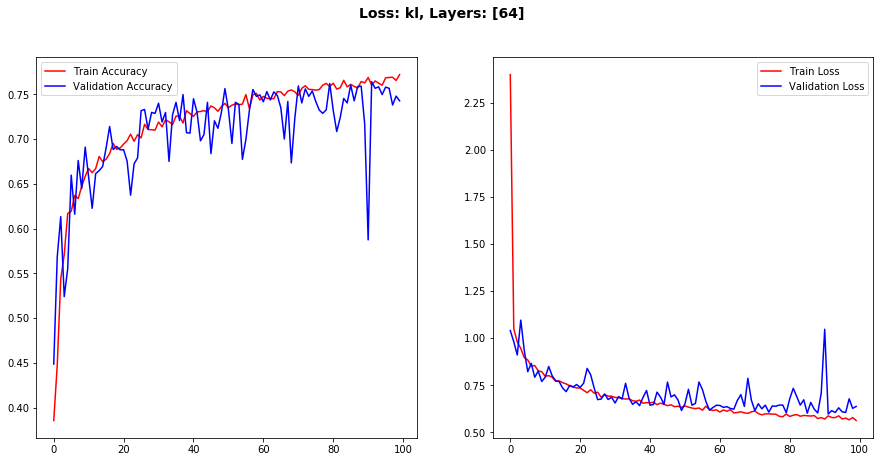

Hidden Layers: [128, 64]
3000/3000 [==============================] - 0s 60us/step
Test Loss: 0.573770, Test Acc: 0.781333


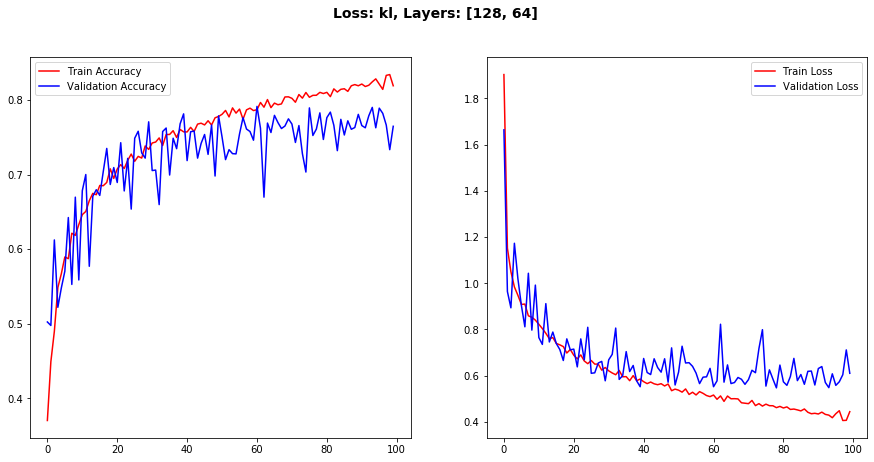

Hidden Layers: [512, 128, 64]
3000/3000 [==============================] - 0s 143us/step
Test Loss: 0.801450, Test Acc: 0.746333


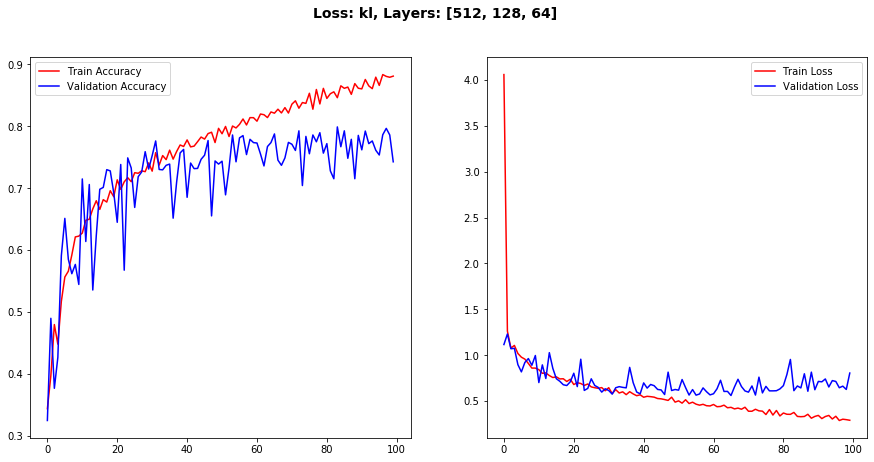

Hidden Layers: [512, 256, 128, 64]
3000/3000 [==============================] - 0s 150us/step
Test Loss: 0.730580, Test Acc: 0.787333


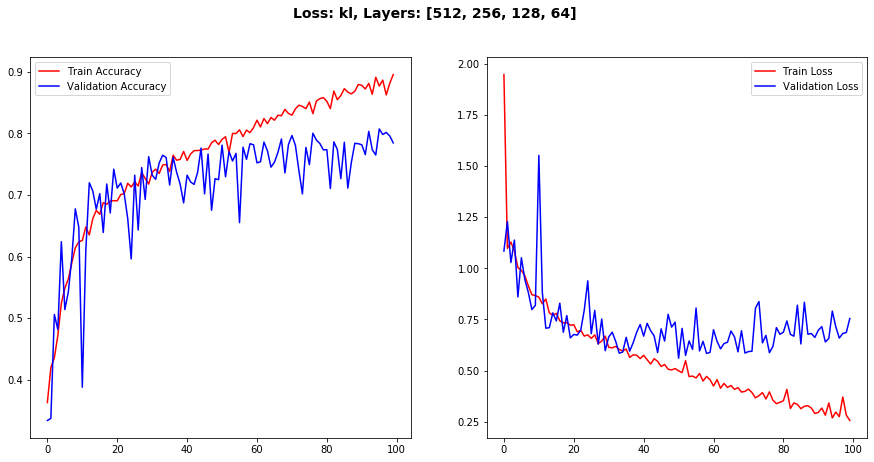

Building Model with Loss: hinge
Hidden Layers: [64]
3000/3000 [==============================] - 0s 99us/step
Test Loss: 0.857912, Test Acc: 0.714667


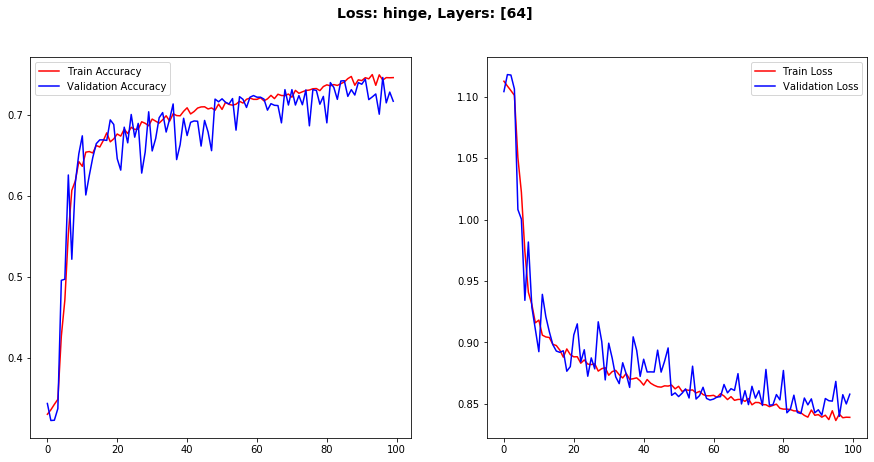

Hidden Layers: [128, 64]
3000/3000 [==============================] - 0s 57us/step
Test Loss: 0.833358, Test Acc: 0.751000


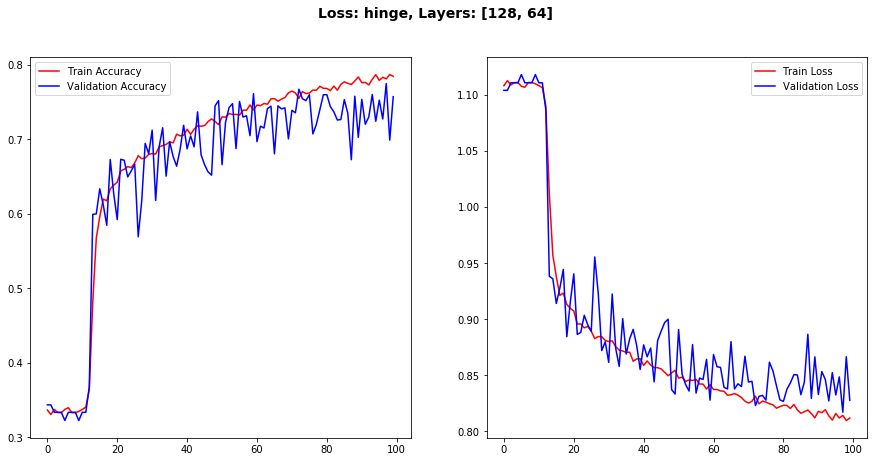

Hidden Layers: [512, 128, 64]
3000/3000 [==============================] - 1s 265us/step
Test Loss: 0.870926, Test Acc: 0.694667


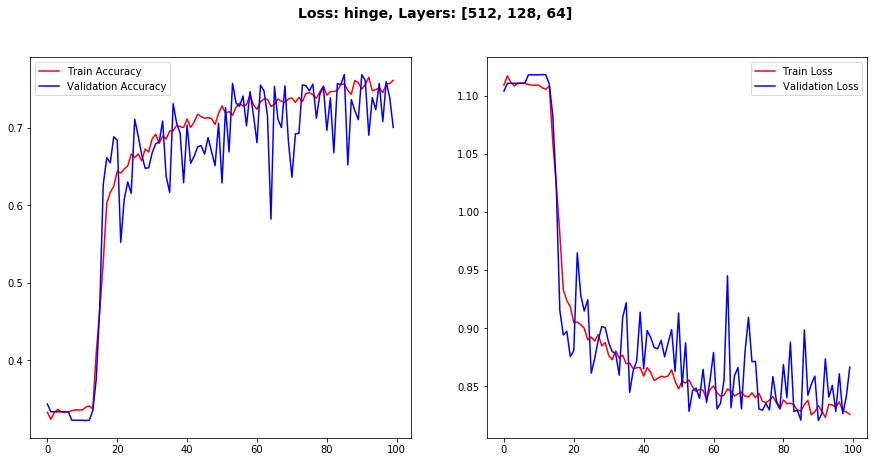

Hidden Layers: [512, 256, 128, 64]
3000/3000 [==============================] - 0s 152us/step
Test Loss: 1.111111, Test Acc: 0.333333


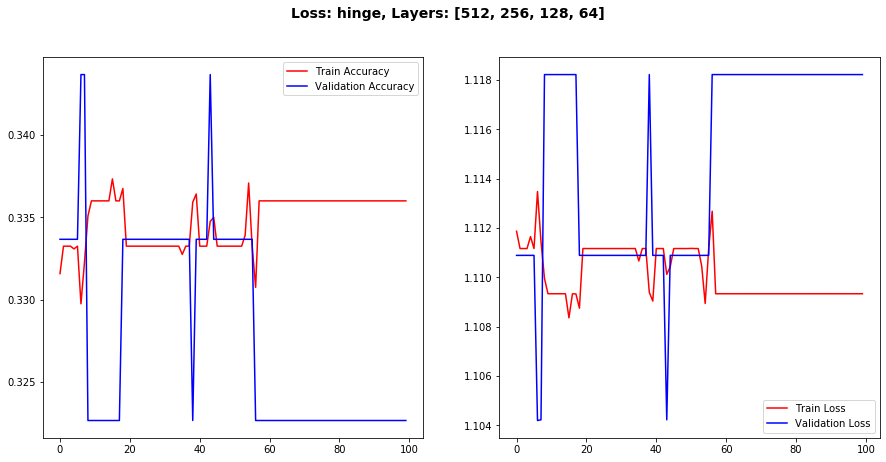

Building Model with Loss: categorical_crossentropy
Hidden Layers: [64]
3000/3000 [==============================] - 0s 59us/step
Test Loss: 0.617739, Test Acc: 0.750000


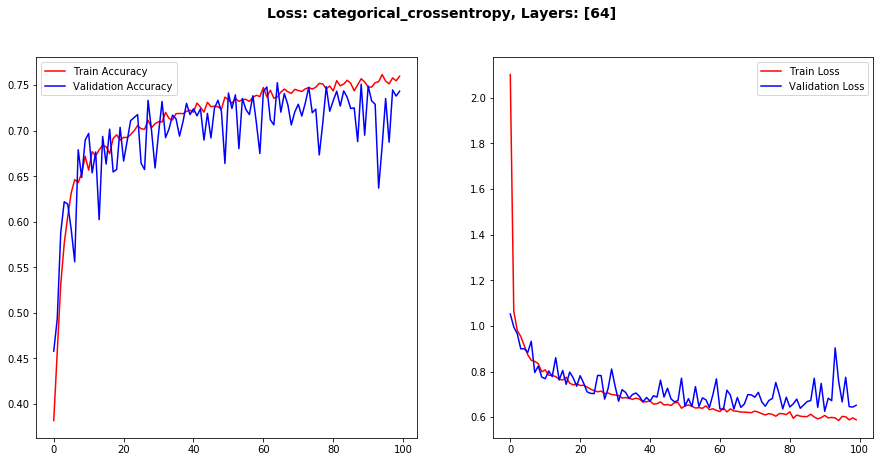

Hidden Layers: [128, 64]
3000/3000 [==============================] - 0s 64us/step
Test Loss: 0.612301, Test Acc: 0.775667


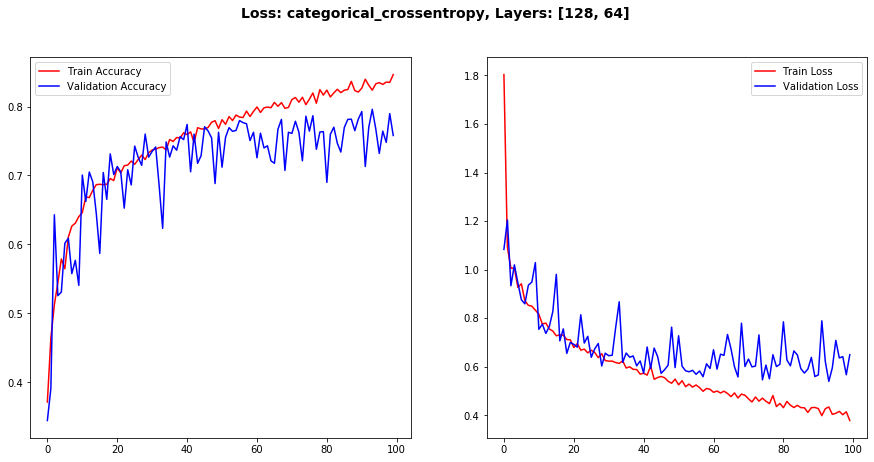

Hidden Layers: [512, 128, 64]
3000/3000 [==============================] - 0s 154us/step
Test Loss: 0.789895, Test Acc: 0.749333


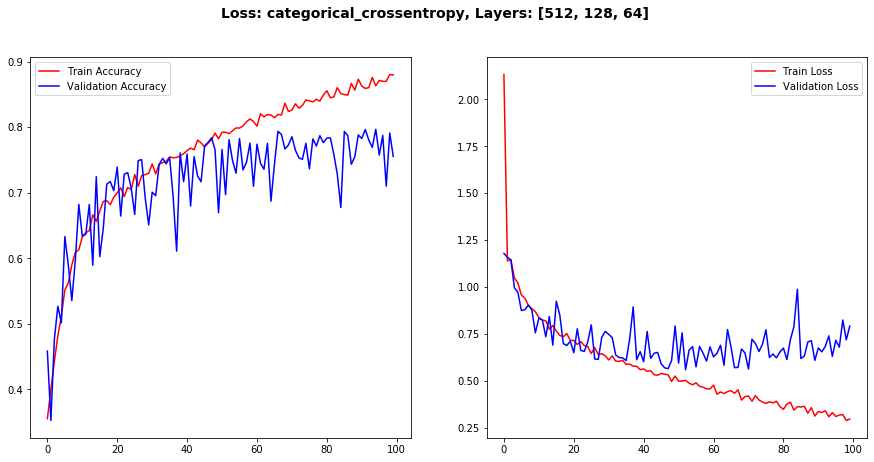

Hidden Layers: [512, 256, 128, 64]
3000/3000 [==============================] - 0s 129us/step
Test Loss: 0.715529, Test Acc: 0.783667


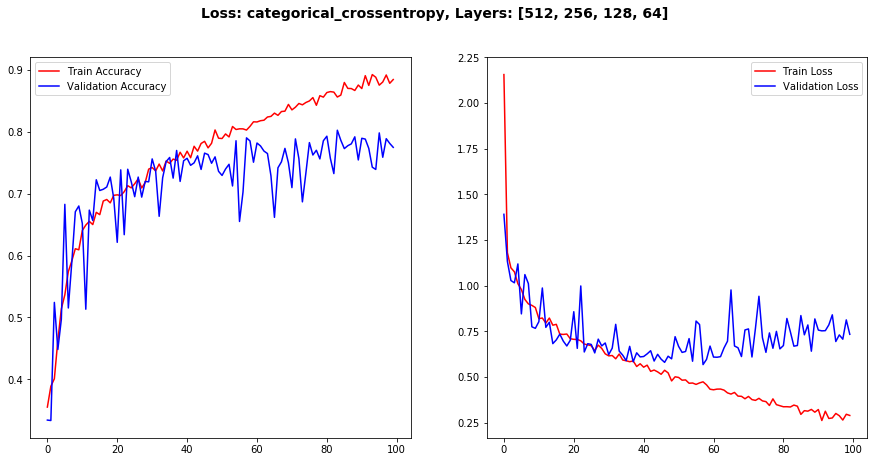

All Combinations:                                                                 [64]  \
kl                         {'Test Loss': 0.6367, 'Test Acc': 0.747}   
hinge                     {'Test Loss': 0.8579, 'Test Acc': 0.7147}   
categorical_crossentropy    {'Test Loss': 0.6177, 'Test Acc': 0.75}   

                                                          [128, 64]  \
kl                        {'Test Loss': 0.5738, 'Test Acc': 0.7813}   
hinge                      {'Test Loss': 0.8334, 'Test Acc': 0.751}   
categorical_crossentropy  {'Test Loss': 0.6123, 'Test Acc': 0.7757}   

                                                     [512, 128, 64]  \
kl                        {'Test Loss': 0.8014, 'Test Acc': 0.7463}   
hinge                     {'Test Loss': 0.8709, 'Test Acc': 0.6947}   
categorical_crossentropy  {'Test Loss': 0.7899, 'Test Acc': 0.7493}   

                                                [512, 256, 128, 64]  
kl                        {'Test Loss': 0.7306, 'Test Ac

In [24]:
# Tuning Losses

batch_size = 512
epochs = 100

losses = ['kl', 'hinge', 'categorical_crossentropy']
hidden_layers = [[64], [128, 64], [512, 128, 64], [512, 256, 128, 64]]
colnames = ['[64]', '[128, 64]', '[512, 128, 64]', '[512, 256, 128, 64]']
metrics = pd.DataFrame({}, index=losses, columns=colnames)
best_model = ""
max_so_far = -np.inf
for i, loss in enumerate(losses):
  print("Building Model with Loss: " + loss)
  for j, hidden_layer in enumerate(hidden_layers):
    print("Hidden Layers: " + str(hidden_layer))
    model = define_classification_model(noclasses = noclasses, num_layers = len(hidden_layer), num_neurons = hidden_layer, 
                         input_shape = (x_train.shape[1],), loss = loss)
    history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
    eval_output = model.evaluate(x_test, y_test)
    if eval_output[1] > max_so_far:
      max_so_far = eval_output[1]
      best_model = "Loss: " + loss + ", Hidden Layers: " + str(hidden_layer)
    metrics.loc[losses[i]][colnames[j]]  = {"Test Loss" : round(eval_output[0], 4), "Test Acc" : round(eval_output[1], 4)}
    
    print("Test Loss: %f, Test Acc: %f" % (eval_output[0], eval_output[1]))
    print_classification_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Loss: " + loss + ", Layers: " + str(hidden_layer))





print("All Combinations: ", metrics)

print("Best Model: ",best_model)

Best Model:  Loss: kl, Hidden Layers: [512, 256, 128, 64]

Building Model with Optimizer: sgd
Learning Rate: 0.0001


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


 448/3000 [===>..........................] - ETA: 0s

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


3000/3000 [==============================] - 1s 287us/step
Test Loss: 1.009239, Test Acc: 0.571000


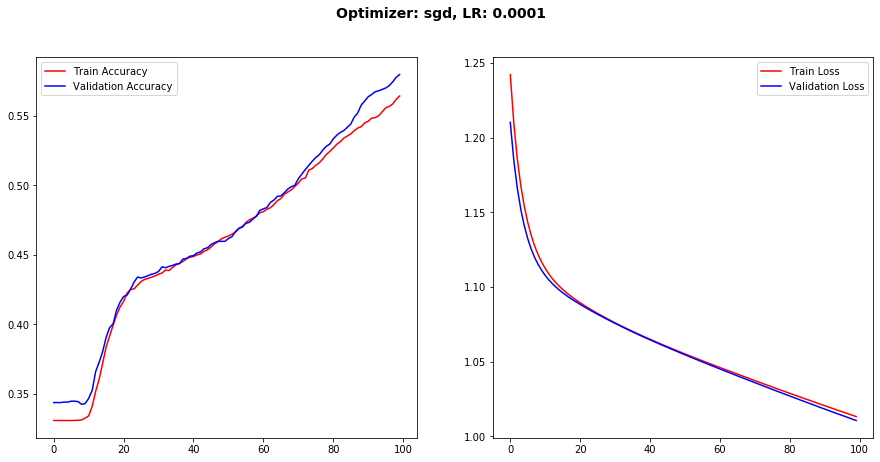

Learning Rate: 0.001
3000/3000 [==============================] - 0s 157us/step
Test Loss: 0.668133, Test Acc: 0.721667


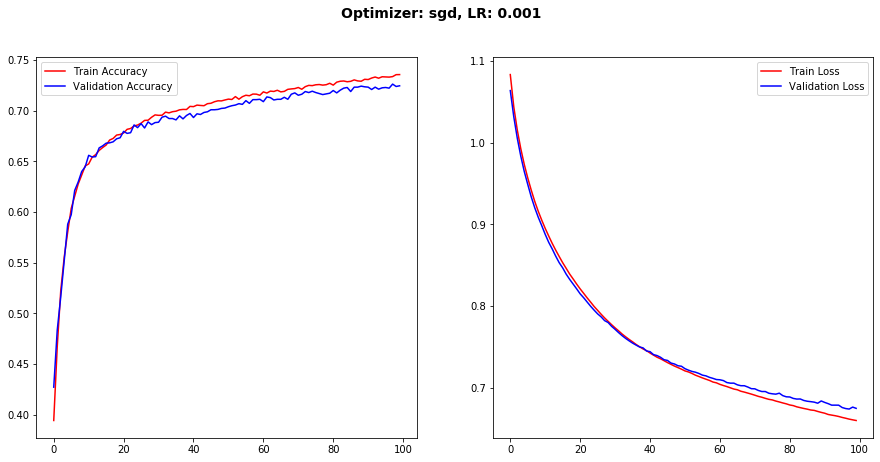

Learning Rate: 0.01
3000/3000 [==============================] - 1s 173us/step
Test Loss: 0.599459, Test Acc: 0.758333


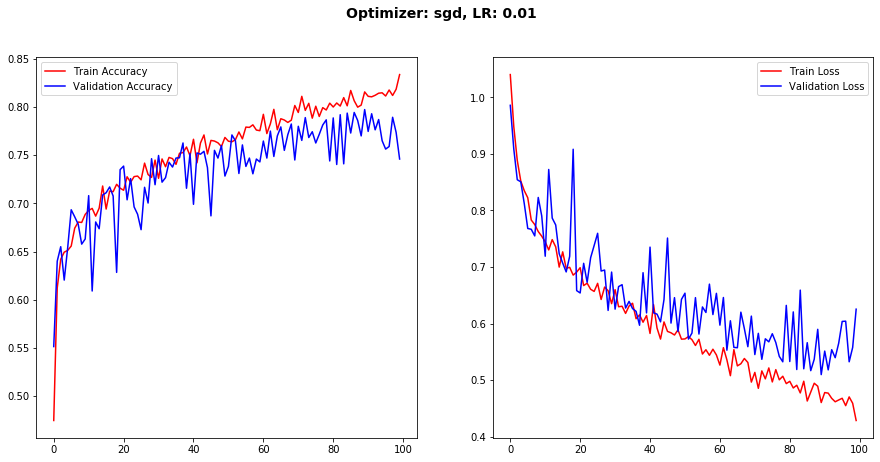

Building Model with Optimizer: RMSprop
Learning Rate: 0.0001
3000/3000 [==============================] - 1s 168us/step
Test Loss: 0.707200, Test Acc: 0.754000


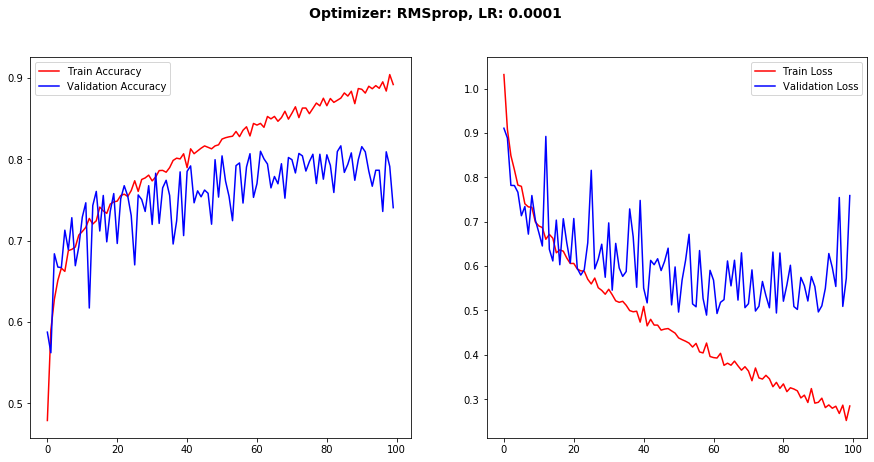

Learning Rate: 0.001
3000/3000 [==============================] - 1s 169us/step
Test Loss: 0.674301, Test Acc: 0.799333


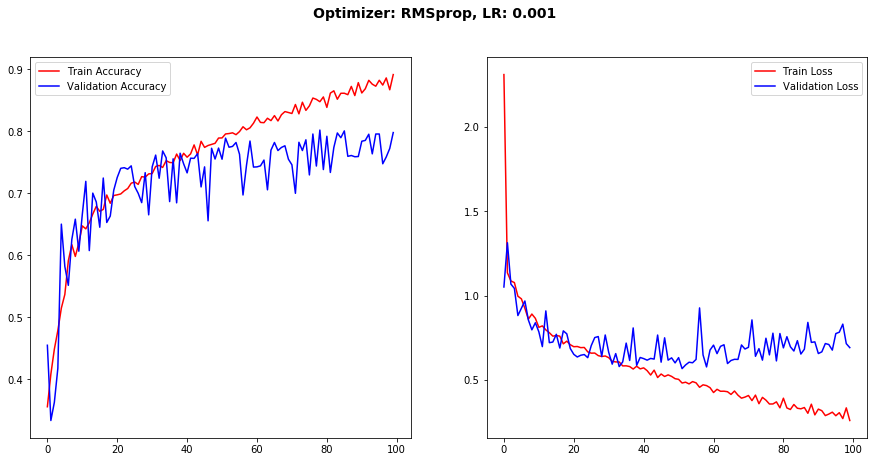

Learning Rate: 0.01
3000/3000 [==============================] - 0s 161us/step
Test Loss: 10.745395, Test Acc: 0.333333


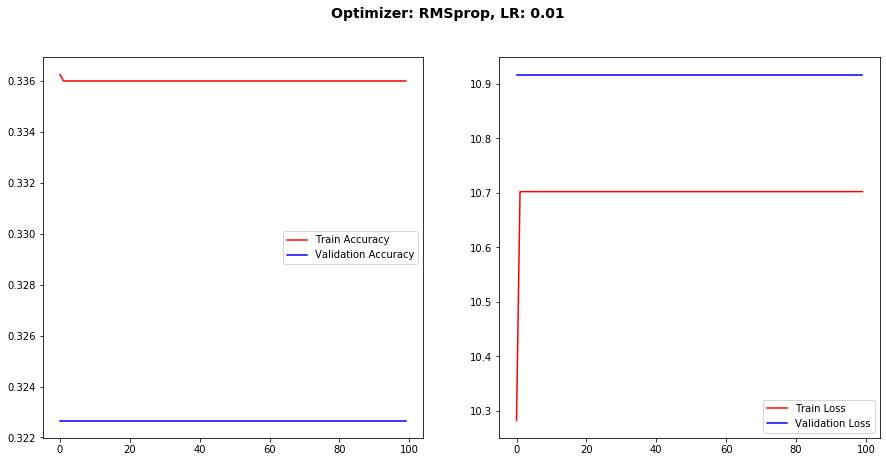

Building Model with Optimizer: Adagrad
Learning Rate: 0.0001
3000/3000 [==============================] - 1s 170us/step
Test Loss: 0.593432, Test Acc: 0.762667


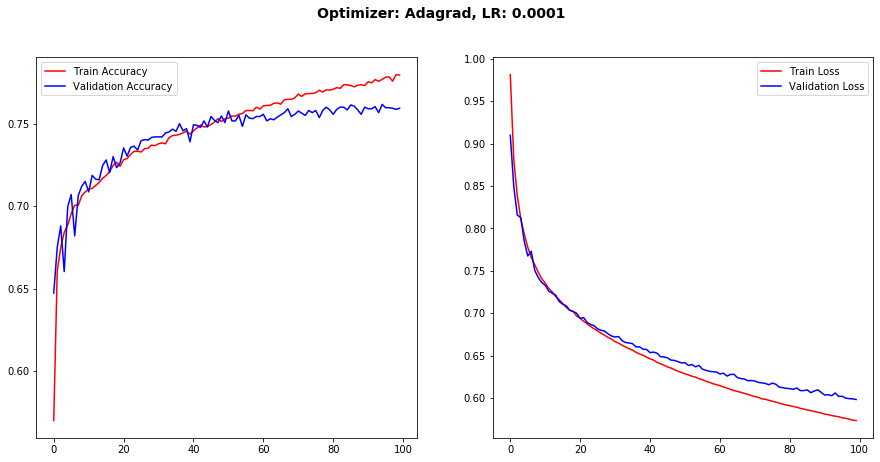

Learning Rate: 0.001
3000/3000 [==============================] - 0s 145us/step
Test Loss: 0.487444, Test Acc: 0.815333


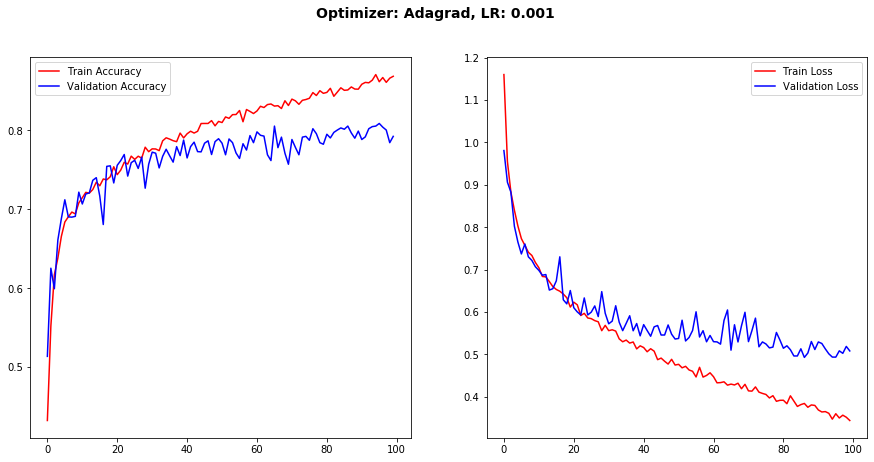

Learning Rate: 0.01
3000/3000 [==============================] - 1s 202us/step
Test Loss: 0.609340, Test Acc: 0.783000


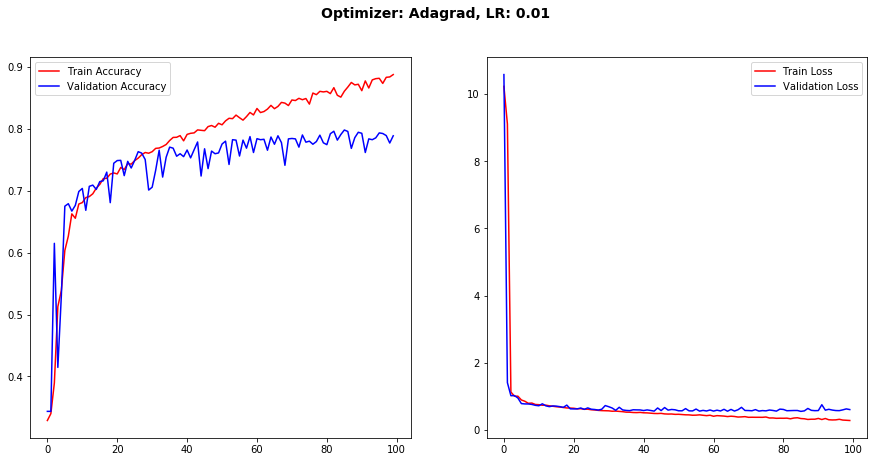

All Combinations:                                      0.0001                             0.0010  \
sgd       {'Acc': 0.571, 'Time': 329.3551}  {'Acc': 0.7217, 'Time': 257.3039}   
RMSprop   {'Acc': 0.754, 'Time': 231.5104}  {'Acc': 0.7993, 'Time': 232.0595}   
Adagrad  {'Acc': 0.7627, 'Time': 208.6171}  {'Acc': 0.8153, 'Time': 207.8885}   

                                    0.0100  
sgd       {'Acc': 0.7583, 'Time': 200.619}  
RMSprop  {'Acc': 0.3333, 'Time': 238.1056}  
Adagrad   {'Acc': 0.783, 'Time': 214.5499}  
Best Model:  Optimizer: Adagrad, Learning Rate: 0.001


In [26]:
# Optimizers

batch_size = 512
epochs = 100

opts = ['sgd', 'RMSprop', 'Adagrad']
lrs = [0.0001, 0.001, 0.01]

metrics = pd.DataFrame({}, index=opts, columns=lrs)
best_model = ""
max_so_far = -np.inf
for i, opt in enumerate(opts):
  print("Building Model with Optimizer: " + opt)

  for j, lr in enumerate(lrs):
    print("Learning Rate: " + str(lr))
    start = time.clock()
    model = define_classification_model(num_layers = 4, num_neurons = [512, 256, 128, 64], 
                         input_shape = (x_train.shape[1],), loss = "kl",
                        optimizer = opt, optimizer_lr = lr)
    history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
    time_taken = time.clock() - start
    test_output = model.evaluate(x_test, y_test)
    metrics.loc[opts[i]][lrs[j]]  = {'Acc' : round(test_output[1], 4), 
                          'Time': round(time_taken, 4)}
    if test_output[1] > max_so_far:
      max_so_far = test_output[1]
      best_model = "Optimizer: " + opt + ", Learning Rate: " + str(lr)
    print("Test Loss: %f, Test Acc: %f" % (test_output[0], test_output[1]))
    print_classification_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Optimizer: " + opt + ", LR: " + str(lr))


print("All Combinations: ", metrics)

print("Best Model: ",best_model)

Best Model:  Optimizer: Adagrad, Learning Rate: 0.001

In [ ]:
# Regularization

batch_size = 512
epochs = 100

regs = ['l1', 'l2', 'l1_l2']
reg_rates = [0.001, 0.005, 0.01]
indexes =  ['L1 Weight Decay', 'L2 Weight Decay', 'L1_L2 Weight Decay']
metrics = pd.DataFrame({}, index=indexes, columns=reg_rates)
for i, regularizer in enumerate(regs):
  print("Building Model with " + regularizer + " weight decay")
  #metrics.loc[i][0] = opt
  for j, reg_rate in enumerate(reg_rates):
    print("Regularization Rate: " + str(reg_rate))
    start = time.clock()
    model = define_classification_model(noclasses = noclasses, num_layers = 4, num_neurons = [512, 256, 128, 64], 
                         input_shape = (x_train.shape[1],), loss = "kl",
                        optimizer = "RMSprop", optimizer_lr = 0.0001,
                        regularizer = regularizer, reg_rate = reg_rate)
    history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
    time_taken = time.clock() - start
    test_output = model.evaluate(x_test, y_test)
    metrics.loc[indexes[i]][reg_rates[j]]  = {'Acc' : round(test_output[1], 4)}
    
    if test_output[1] > max_so_far:
      min_so_far = test_output[1]
      best_model = "Regularizer: " + regularizer + ", Regularization Rate: " + str(reg_rate)
    print("Test Loss: %f, Test Acc: %f" % (test_output[0], test_output[1]))
    print_classification_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Regularizer: " + regularizer + ", Regularization Rate: " + str(reg_rate))



print("All Combinations: ", metrics)

print("Best Model: ",best_model)

In [ ]:
# Dropout


batch_size = 512
epochs = 100

dropouts = np.arange(0.2, 0.55, 0.05)
metrics = pd.DataFrame({}, index=dropouts, columns=['Acc'])
for i, dropout in enumerate(dropouts):
  print("Building Model with Dropout:" + str(dropout))
  print("Regularization Rate: " + str(reg_rate))
  start = time.clock()
  model = define_classification_model(noclasses = noclasses, num_layers = 4, num_neurons = [512, 256, 128, 64], 
                         input_shape = (x_train.shape[1],), loss = "kl",
                        optimizer = "RMSprop", optimizer_lr = 0.0001,
                        dropout = dropout)
  history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
  time_taken = time.clock() - start
  test_output = model.evaluate(x_test, y_test)
  metrics.loc[dropouts[i]]['Acc']  = {'Acc' : round(test_output[1], 4)}
    
  if test_output[1] > max_so_far:
    max_so_far = test_output[1]
    best_model = "Dropout: " + str(dropout)
  print("Test Loss: %f, Test Acc: %f" % (test_output[0], test_output[1]))
  print_classification_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Dropout: " + str(dropout))


print("All Combinations: ", metrics)

print("Best Model: ",best_model)

3000/3000 [==============================] - 1s 211us/step
Test Loss: 0.671842, Test Acc: 0.798667


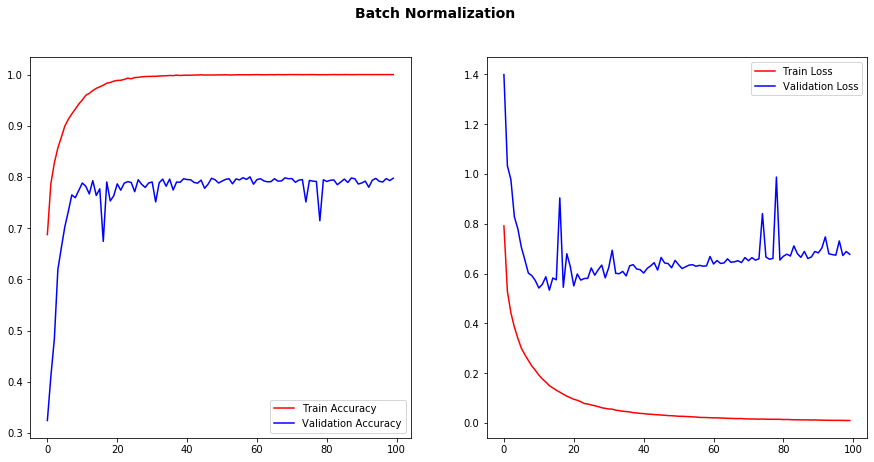

In [28]:
#Batch Normalization

model = define_classification_model(noclasses = noclasses, num_layers = 4, num_neurons = [512, 256, 128, 64], 
                         input_shape = (x_train.shape[1],), loss = "kl",
                        optimizer = "Adagrad", optimizer_lr = 0.001,
                        batch_norm = True)
history = model.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data = (x_val, y_val),
                     verbose = 0)
test_output = model.evaluate(x_test, y_test)
print("Test Loss: %f, Test Acc: %f" % (test_output[0], test_output[1]))
print_classification_graphs(history=history, epochs = epochs, batch_size = batch_size, 
                 plot_title = "Batch Normalization")

